# Modeling
### plan
> Model1.  <br>
기상청 데이터를 활용해서 외부 날씨 예측 => 시계열
* 이때, test데이터에는 30분 단위 값도 있고, 기상청 데이터는 1시간 단위이므로 기상청 데이터에 30분단위도 추가필요
* 같은시간대의 데이터만 가져와서 시간대별로 예측하는 방식

> Model2. <br>
Model1 에서 예측한 외부 날씨와 공장내부 온도,습도,코일온도,이슬점온도 등의 정보로 결로현상 예측 => 분류, 로지스틱회귀


#### 결로 대책
* 결로대책 관련
    * 내외부 온도차가 결로에 얼마나 영향을 미치는지 (영향의 정도?에 대한 인사이트)
        온도차 말고도 기타 습도와 같은 어떤 요사가 어느정도의 영향을 미친다고 할 수 있는지를 보여줄 수 있는 지표 ?
    * 신뢰구간을 제시해서 온도 또는 습도 (기타 요소) 등이 어느 신뢰구간 수준을 벗어나면 결로발생할 수 있다는 알람 ? 경고를 표시하는 등의 제안할 수 있을 듯
        * 시각화한 자료로 대충 보여주는것도..
    * 다른 회사에서는 결로 방지를 위해 어떤 대책을 마련하고 있는지에 대한 조사 
        * 여기 나와있는 자료도 충분해보이기는 함
* 4) 결로대책 - 기상예보의 활용 (이부분 갖다 쓰기 좋은듯)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from itertools import cycle
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [2]:
# jupyter notebook cell 너비 조절
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

In [3]:
# 한글깨짐 문제
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [4]:
plant1_train=pd.read_csv('./data/plant1_train.csv',index_col=[0],parse_dates=['plant1_train.mea_ddhr'])
plant2_train=pd.read_csv('./data/plant2_train.csv',index_col=[0],parse_dates=['plant2_train.mea_ddhr'])
plant_test=pd.read_csv('./data/plant_test.csv',index_col=[0],parse_dates=['plant_test.mea_ddhr'])

# 당진
dangjin_humid=pd.read_csv('./data/dangjin_humid.csv',index_col=None)
dangjin_rain=pd.read_csv('./data/dangjin_rain.csv',index_col=None)
dangjin_tem=pd.read_csv('./data/dangjin_tem.csv',index_col=None)

# 신평
shinpyung_humid=pd.read_csv('./data/shinpyung_humid.csv',index_col=None)
shinpyung_rain=pd.read_csv('./data/shinpyung_rain.csv',index_col=None)
shinpyung_tem=pd.read_csv('./data/shinpyung_tem.csv',index_col=None)

# 서산
seosan=pd.read_csv('./data/asos_서산_시간별.csv',index_col=None,parse_dates=['일시'])

# test데이터셋과 동일하게 train 데이터 전처리
plant_train=pd.read_csv('./data/plant_train.csv',index_col=[0])

In [5]:
# 서산
seosan=pd.read_csv('./data/asos_서산_시간별.csv',index_col=None,parse_dates=['일시'])

### 컬럼명 전처리

In [5]:
# 날씨 컬럼명 정리
dangjin = [dangjin_tem, dangjin_rain, dangjin_humid]
#seosan=[seosan]

for d in dangjin:
    d.columns = [col.split('.')[1] for col in d.columns]    
    d.rename(columns={'tm':'datetime'}, inplace=True)    

In [6]:
# 공장 컬럼명 정리
plant = [plant1_train, plant2_train, plant_test]

for p in plant:
    p.columns = [col.split('.')[1] for col in p.columns]    
    p.rename(columns={'mea_ddhr':'datetime'}, inplace=True)    

### 기온, 습도, 이슬점온도 컬럼 분리

In [7]:
# 30분단위 추가 전
seosan_hum=seosan[['일시','습도(%)']]
seosan_hum.columns=['일시','습도']
seosan_dew=seosan[['일시','이슬점온도(°C)']]
seosan_dew.columns=['일시','이슬점온도']
seosan_tem=seosan[['일시','기온(°C)']]
seosan_tem.columns=['일시','기온']
#seosan_tem=seosan_tem.iloc[:26246]     # train 데이터 분리.

### 30분 단위 추가

In [8]:
index_30min=pd.date_range('2016-04-01 00:30:00', periods=35231, freq='H')
index_30min=index_30min.to_frame().rename(columns={0:'일시'})
seosan2=pd.concat([seosan,index_30min],ignore_index=True)
seosan2=seosan2.sort_values('일시').reset_index(drop=True)
seosan2.head()

,지점,지점명,일시,기온(°C),기온 QC플래그,강수량(mm),강수량 QC플래그,풍속(m/s),풍속 QC플래그,풍향(16방위),풍향 QC플래그,습도(%),습도 QC플래그,증기압(hPa),이슬점온도(°C),현지기압(hPa),현지기압 QC플래그,해면기압(hPa),해면기압 QC플래그,일조(hr),일조 QC플래그,일사(MJ/m2),적설(cm),3시간신적설(cm),전운량(10분위),중하층운량(10분위),운형(운형약어),최저운고(100m ),시정(10m),지면상태(지면상태코드),현상번호(국내식),지면온도(°C),지면온도 QC플래그,5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C)
0,129.0,서산,2016-04-01 00:00:00,8.8,0.0,NaN,NaN,1.5,0.0,50.0,0.0,41.0,0.0,4.6,-3.7,1012.1,0.0,1015.6,0.0,NaN,9.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2000.0,NaN,NaN,4.0,0.0,NaN,NaN,NaN,NaN
1,NaN,NaN,2016-04-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,129.0,서산,2016-04-01 01:00:00,9.2,0.0,NaN,NaN,1.2,0.0,50.0,0.0,34.0,0.0,4.0,-5.8,1011.7,0.0,1015.2,0.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000.0,NaN,NaN,3.4,0.0,NaN,NaN,NaN,NaN
3,NaN,NaN,2016-04-01 01:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,129.0,서산,2016-04-01 02:00:00,9.2,0.0,NaN,NaN,1.1,0.0,20.0,0.0,33.0,0.0,3.8,-6.2,1011.3,0.0,1014.8,0.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000.0,NaN,NaN,3.3,0.0,NaN,NaN,NaN,NaN


### 30분단위 추가 후  기온, 습도, 이슬점온도 분류

In [9]:
# 30분단위 추가 후  기온, 습도, 이슬점온도 분류
seosan_hum2=seosan2[['일시','습도(%)']]
seosan_hum2.columns=['일시','습도']
seosan_dew2=seosan2[['일시','이슬점온도(°C)']]
seosan_dew2.columns=['일시','이슬점온도']
seosan_tem2=seosan2[['일시','기온(°C)']]
seosan_tem2.columns=['일시','기온']
#seosan_tem=seosan_tem.iloc[:26246]     # train 데이터 분리.

In [10]:
seosan_tem2.head()

,일시,기온
0,2016-04-01 00:00:00,8.8
1,2016-04-01 00:30:00,NaN
2,2016-04-01 01:00:00,9.2
3,2016-04-01 01:30:00,NaN
4,2016-04-01 02:00:00,9.2


### 결측값 보간

In [11]:
seosan_tem2=seosan_tem2.interpolate()
seosan_hum2=seosan_hum2.interpolate()
seosan_dew2=seosan_dew2.interpolate()
print('기온 결측치:',seosan_tem2.isnull().sum())
print('습도 결측치:',seosan_hum2.isnull().sum())
print('이슬점온도 결측치:',seosan_dew2.isnull().sum())

기온 결측치: 일시    0
기온    0
dtype: int64
습도 결측치: 일시    0
습도    0
dtype: int64
이슬점온도 결측치: 일시       0
이슬점온도    0
dtype: int64


In [12]:
seosan_tem2.head()

,일시,기온
0,2016-04-01 00:00:00,8.8
1,2016-04-01 00:30:00,9.0
2,2016-04-01 01:00:00,9.2
3,2016-04-01 01:30:00,9.2
4,2016-04-01 02:00:00,9.2


------------------------------------------------------------------------------------------------------------------------------------------------
## ARIMA 모델

#### 500일 이전시점 train & predict 
* 시간대 4:30 인것만 500일 가져오기
* 2019-04-01 04:30 이전 500일 데이터로 2019-04-02 04:30 과, 2019-04-03 04:30 값 예측

In [13]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [14]:
# 4시반 데이터만 일자별로 가져오기
hour4_30=seosan_tem2[(seosan_tem2['일시'].apply(lambda x:x.hour)==4)]
hour4_30=hour4_30[(hour4_30['일시'].apply(lambda x:x.minute)==30)].reset_index(drop=True)
hour4_30

,일시,기온
0,2016-04-01 04:30:00,4.20
1,2016-04-02 04:30:00,4.60
2,2016-04-03 04:30:00,8.90
3,2016-04-04 04:30:00,7.15
4,2016-04-05 04:30:00,1.50
...,...,...
1463,2020-04-03 04:30:00,1.55
1464,2020-04-04 04:30:00,6.05
1465,2020-04-05 04:30:00,4.10
1466,2020-04-06 04:30:00,-1.30


In [15]:
# 2019-04-01 4:30 포함해서 이전 500일
### 2019-04-01 04:30 이전 500일 데이터로 두시점 이후 예측 (24h, 48h)
day_500=hour4_30[1096-(500):1096].set_index('일시')
day_500

,기온
일시,
2017-11-18 04:30:00,1.30
2017-11-19 04:30:00,-2.05
2017-11-20 04:30:00,0.05
2017-11-21 04:30:00,-3.30
2017-11-22 04:30:00,2.00
...,...
2019-03-28 04:30:00,4.95
2019-03-29 04:30:00,5.75
2019-03-30 04:30:00,4.60


#### (연습) for문으로 데이터 append


In [61]:
# series에 array 를 append
ser=pd.Series()
for i in range(5):
    result=pd.Series(np.array([i*2]))
    np.append(ser,result)
    print(result)

0    0
dtype: int64
0    2
dtype: int64
0    4
dtype: int64
0    6
dtype: int64
0    8
dtype: int64


In [95]:
# array 와 array를 append할경우.
arr=np.array([])
for i in range(5):
    result=np.array([i*2])
    np.append(arr,result)
    print(result)

[0]
[2]
[4]
[6]
[8]


In [72]:
# list에 array를 append할경우
list=[]
for i in range(5):
   # result=np.array([i*2]).tolist()
    result=np.array([i*2])
    list.append(result)
print(list)

[array([0]), array([2]), array([4]), array([6]), array([8])]


In [73]:
# list에 list를 append할경우
list=[]
for i in range(5):
    result=np.array([i*2]).tolist()
    list.append(result)
print(list)

[[0], [2], [4], [6], [8]]


In [141]:
# train = 1000
# test= 1468-1000=468
hour4_30=seosan_tem2[(seosan_tem2['일시'].apply(lambda x:x.hour)==4)]
hour4_30=hour4_30[(hour4_30['일시'].apply(lambda x:x.minute)==30)].reset_index(drop=True)
hour4_30

,일시,기온
0,2016-04-01 04:30:00,4.20
1,2016-04-02 04:30:00,4.60
2,2016-04-03 04:30:00,8.90
3,2016-04-04 04:30:00,7.15
4,2016-04-05 04:30:00,1.50
...,...,...
1463,2020-04-03 04:30:00,1.55
1464,2020-04-04 04:30:00,6.05
1465,2020-04-05 04:30:00,4.10
1466,2020-04-06 04:30:00,-1.30


#### 테스트용 코드
* list에 array값을 append한결과
    * [array([23.95573504]), array([22.79908278]), array([23.09846874]),....
        * array하나에 붙게 나오게하려면 -> list[0][0] 출력

In [23]:
list(range(0,5))

[0, 1, 2, 3, 4]

In [34]:
hour4_30.shape[0]

1468

In [27]:
hour4_30.shape[0]-500

968

In [99]:
hour4_30[:100].shape[0]-20

80

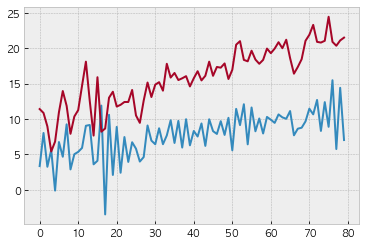

[3.3372238066019926, 8.017499815831647, 3.237451635750222, 5.619198709233082, -0.12499822560852829, 6.741305627475418, 4.654584486832464, 9.239921407877063, 2.864995182682306, 5.016456766043228, 5.346541676392513, 5.9049994698337045, 9.036557815471054, 9.149377207489575, 3.586785849702251, 4.0893393124557385, 11.889908347928246, -3.494775803549584, 10.593442411420815, 2.08385983698807, 8.879651171807868, 2.39632336829095, 7.441792265287524, 3.924234797002612, 6.7076558217606435, 5.798639780304329, 3.977411463674307, 4.611779432944823, 9.07999816491628, 6.9414290020404685, 6.4224993752057715, 8.684682753360141, 6.43138468127695, 7.6724911277424095, 9.817279175728409, 6.604093967729506, 9.73042715384569, 5.95920809984533, 9.96116962102239, 6.269899259945216, 8.29884239064587, 7.516435961002421, 9.364357719285454, 6.189804079779463, 9.956919744504482, 8.279027332836948, 7.880983165708408, 9.68495992827353, 7.74166027566169, 10.16249999999998, 5.5669409268914025, 11.42955073198834, 9.12736

In [111]:
############################################################################## 테스트용 (100일치)
from statsmodels.tsa.arima_model import ARIMA
hour4_30=seosan_tem2[(seosan_tem2['일시'].apply(lambda x:x.hour)==4)]
hour4_30=hour4_30[(hour4_30['일시'].apply(lambda x:x.minute)==30)].reset_index(drop=True)

list=[]
test_list=[]
period=20
for i in range(0, hour4_30[:100].shape[0]-20):   # i = 0~968 (총1468이지만 그전까지 예측해야하므로)
    train=hour4_30[:100].iloc[ i: period+i].set_index('일시')  # train= 0~500, 1~501, 2~502 ...(1467-500)=967~1467
    test=hour4_30[:100].iloc[period+i]['기온']  # 501,502,503,,,,1468
    model = ARIMA(train, order=(0,0,1))
    model_fit = model.fit(trend='nc',full_output=True, disp=1)
    fore = model_fit.forecast(steps=1)
    list.append(fore[0])
    test_list.append(test)
    
plt.plot(list)
plt.plot(test_list)
plt.show()

print(list)

In [66]:
hour4_30

,일시,기온
0,2016-04-01 04:30:00,4.20
1,2016-04-02 04:30:00,4.60
2,2016-04-03 04:30:00,8.90
3,2016-04-04 04:30:00,7.15
4,2016-04-05 04:30:00,1.50
...,...,...
1463,2020-04-03 04:30:00,1.55
1464,2020-04-04 04:30:00,6.05
1465,2020-04-05 04:30:00,4.10
1466,2020-04-06 04:30:00,-1.30


In [68]:
hour4_30.shape

(1468, 2)

In [79]:
hour4_30.iloc[1467]

일시    2020-04-07T04:30:00.000000000
기온                                3
Name: 1467, dtype: object

In [81]:
1468-500-1+500

1467

------------------------------------------------------------------------------------------------------------------------------------------------
# [정리] 하루씩 shifting해서 500일 기준으로 ARIMA적용
TODO
* substr으로 시간대 유니크하게 만들고 , 시간별로 가져오게끔 for문 작성

**about ARIMA model** <br>
* 계절성을 띌 경우 SARIMA모델 사용
    * 이때는 seasonal component에 상응하는 또 다른 P,D,Q값을 정해야 함.
* 대부분 사람들이 ARIMA적용시, 외부 변수들을 많이 넣으려고하는데 ARIMA모델은 외부변수를 넣지 않을때가 가장 파워풀함.

In [ ]:
hour4_30=seosan_tem2[(seosan_tem2['일시'].apply(lambda x:x.hour)==4)]
hour4_30=hour4_30[(hour4_30['일시'].apply(lambda x:x.minute)==30)].reset_index(drop=True)
hour4_30

In [23]:
# 2016년 4월~ 2020년 4월 (4년) 일자의 4시 30분 값만 가져옴.
hour4_30

,일시,기온
0,2016-04-01 04:30:00,4.20
1,2016-04-02 04:30:00,4.60
2,2016-04-03 04:30:00,8.90
3,2016-04-04 04:30:00,7.15
4,2016-04-05 04:30:00,1.50
...,...,...
1463,2020-04-03 04:30:00,1.55
1464,2020-04-04 04:30:00,6.05
1465,2020-04-05 04:30:00,4.10
1466,2020-04-06 04:30:00,-1.30


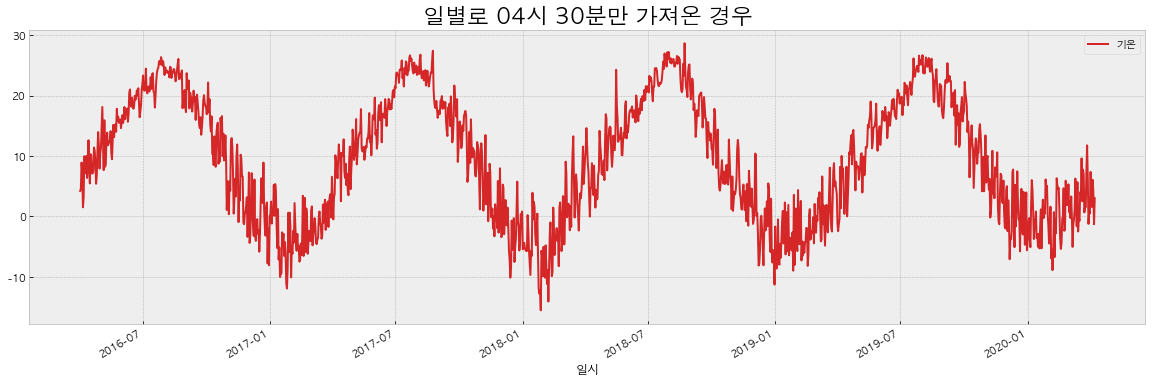

In [82]:
# 4시반
fig,ax=plt.subplots()
fig.set_size_inches(20,6)
fig=hour4_30.set_index('일시').plot(ax=ax, color=color[3])
plt.title('일별로 04시 30분만 가져온 경우',fontsize=22)
plt.show()

### Seasonal Decomposition (STL)
* trend가 선형적이고, 계절성이있으며, 일정할 경우 additive model 사용
* non linear rate에서 증가하거나 감소하는 데이터의 경우 multiplicative model 사용

<Figure size 432x288 with 0 Axes>

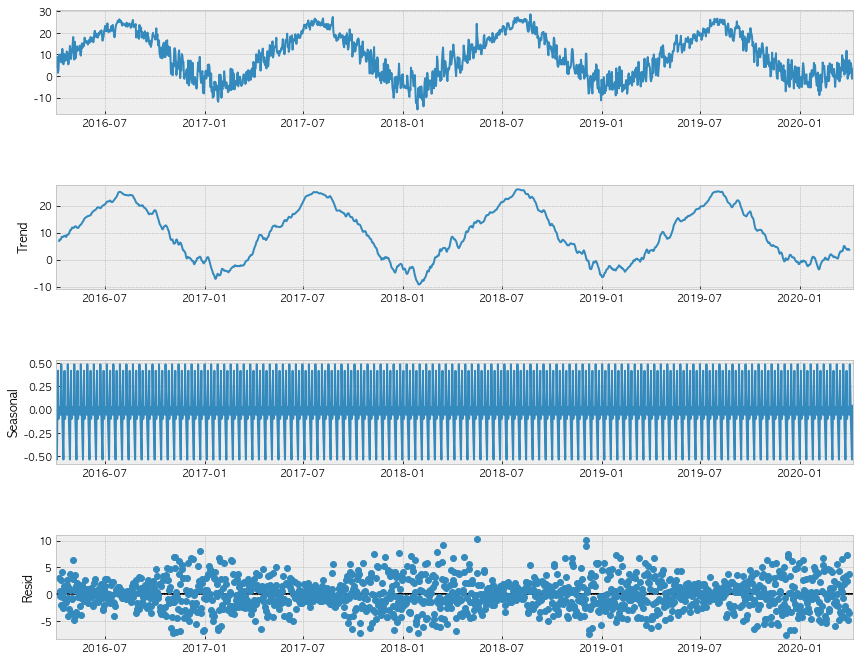

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(hour4_30.set_index('일시'), freq=12)  
fig = plt.figure()  
fig = decomposition.plot()
fig.set_size_inches(13,10)

### 정상성 확인
일반적으로 데이터가 stationary한 경우는 거의 없음. 정상성을 Test하기 위해서 두가지 방법 사용

1. 눈으로 직관적 확인 ~ STL, Rolling statistics(moving average) 
2. Dickey-FUller test 
    * https://datascienceschool.net/view-notebook/ebb638fc880145b9adeef8dfa630f067/
    * 귀무가설이 non-stationary 이므로, p-value < 0.05 이어야 stationary하다고 할 수 있음.

In [83]:
from statsmodels.tsa.stattools import adfuller

In [85]:
# 정상성 검증 
print( "검정통계량:" ,adfuller(hour4_30.set_index('일시'))[0])
print( "p-value:" ,adfuller(hour4_30.set_index('일시'))[1])
print( "사용된 시차의 수:" ,adfuller(hour4_30.set_index('일시'))[2])
print( "자료의 수:" ,adfuller(hour4_30.set_index('일시'))[3])
print( "1%,5%,10%수준에 해당되는 검정통계량의 값:" ,adfuller(hour4_30.set_index('일시'))[4])

검정통계량: -1.5922324856618044
p-value: 0.4874942189670485
사용된 시차의 수: 13
자료의 수: 1454
1%,5%,10%수준에 해당되는 검정통계량의 값: {'1%': -3.4348554210983093, '5%': -2.8635298424390276, '10%': -2.5678293754552732}


* 위의 경우 p-value > 0.05 이므로 non-stationary

### 정상화 Stationarize
1. 차분(differencing): 1차차분. Trend 제거하는데 용이 $\Delta y_{t} = y_{t} - y_{t-1}$
2. 로그변환(lograithm): 표준편차가 자료의 크기에 비례하여 증가할때
3. Box-Cox 변환: 정규분포가 아닌 자료를 정규분포로 변환.

In [90]:
# 차분 후 정상성 검증 
diff_1=hour4_30.set_index('일시').diff(periods=1).iloc[1:]

print( "검정통계량:" ,adfuller(diff_1)[0])
print( "p-value:" ,adfuller(diff_1)[1])
print( "사용된 시차의 수:" ,adfuller(diff_1)[2])
print( "자료의 수:" ,adfuller(diff_1)[3])
print( "1%,5%,10%수준에 해당되는 검정통계량의 값:" ,adfuller(diff_1)[4])

검정통계량: -15.493499477454272
p-value: 2.4674643841389903e-28
사용된 시차의 수: 12
자료의 수: 1454
1%,5%,10%수준에 해당되는 검정통계량의 값: {'1%': -3.4348554210983093, '5%': -2.8635298424390276, '10%': -2.5678293754552732}


* 1차 차분 후 p-value < 0.05 이므로 stationary

### acf, pacf plot 
* ACF가 서서히 감소하고, PACF가 급격히 0에 근접한 값을 가지면 AR(p)모형 선정 (O)
    * 우리 데이터는 아래와같이 ACF는 서서히 감소하고, PACF는 급격히 떨어지는 형태이므로 AR(p)모형 적합
* ACF가 급격히 0에 근접한 값을 가지고, PACF가 서서히 감소하면 MA(q)모형 선정
* ACF, PACF 모두 특정 차수 이상에서 없어지는 현상이 나타나지 않는다면 ARMA 모형을 사용해야 한다.

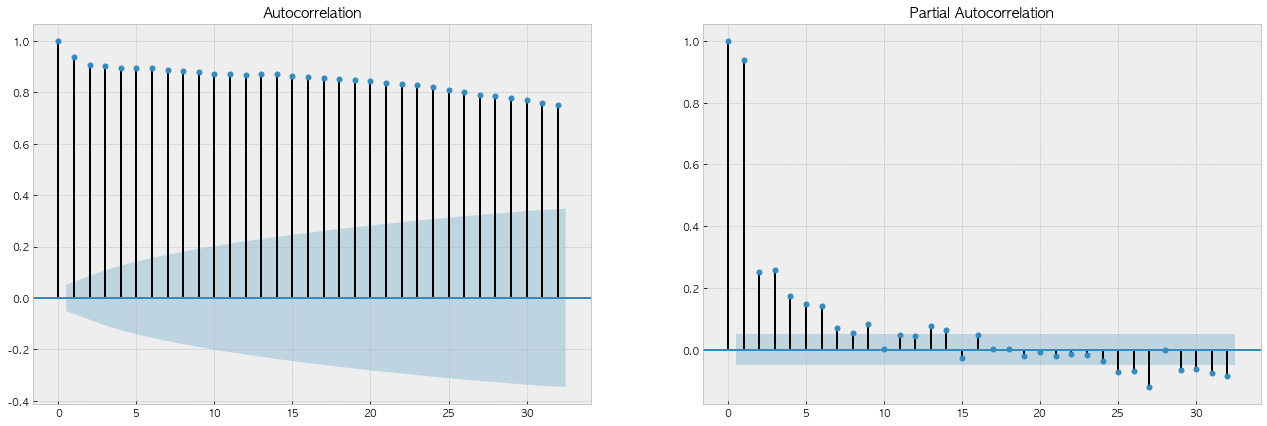

In [54]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(22,7)
plot_acf(hour4_30.set_index('일시'),ax=ax1)
plot_pacf(hour4_30.set_index('일시'),ax=ax2)
plt.show()

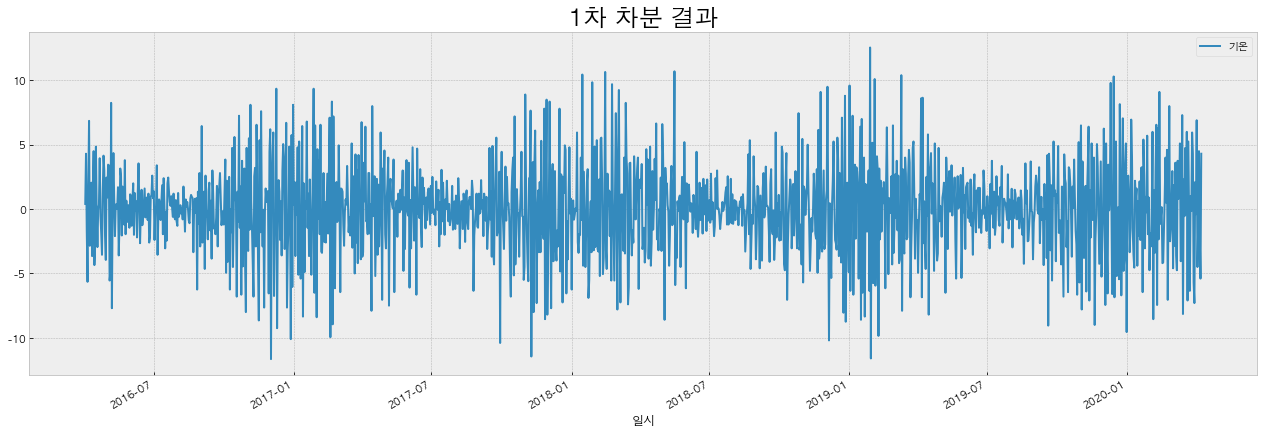

In [63]:
# 1차 차분 결과
fig,ax=plt.subplots()
fig.set_size_inches(22,7)
diff_1=hour4_30.set_index('일시').diff(periods=1).iloc[1:]
diff_1.plot(ax=ax)
plt.title('1차 차분 결과',fontsize=24)
plt.show()

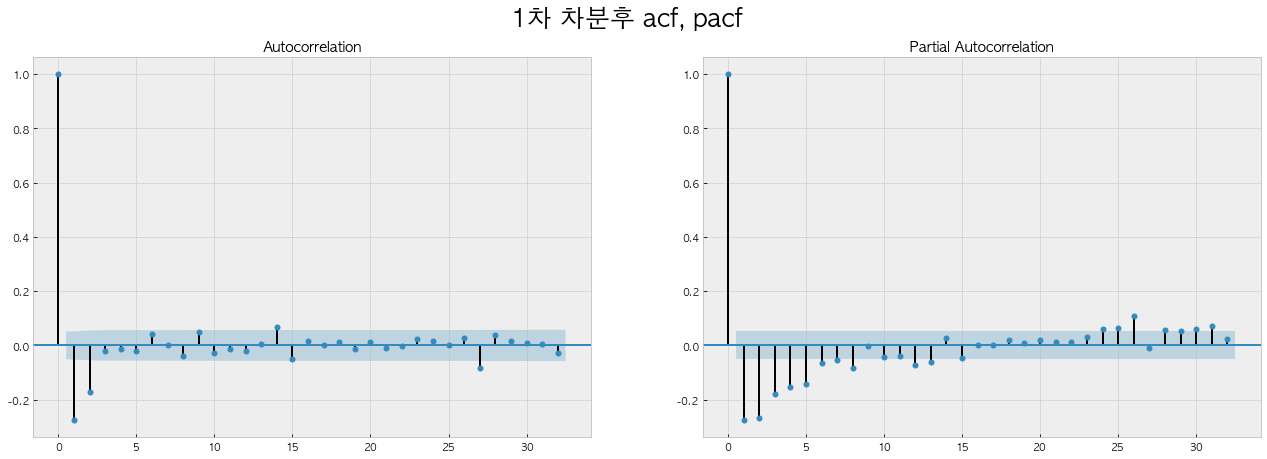

In [66]:
# 1차 차분결과
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(22,7)
diff_1=hour4_30.set_index('일시').diff(periods=1).iloc[1:]
plot_acf(diff_1,ax=ax1)
plot_pacf(diff_1,ax=ax2)
plt.suptitle('1차 차분후 acf, pacf',fontsize=25)
plt.show()

* 결론적으로, 위의 과정을 통해 p,d,q 값은 (4,1,2) 로 산정할 수 있어보임.
    * acf-plot 으로 q값 결정 => 2시점 이후로 범위내에 들어옴
    * pacf-plot으로 p값 결정 => 4시점 이후로 범위내에 들어옴

### ARIMA모형 적합


In [97]:
model = ARIMA(hour4_30.set_index('일시'), order=(4,1,2))  
model_fit = model.fit(trend='nc', full_output=True,disp=1)   # 'nc' = 결정론적 추세 없음. DF검정, 'c' = 상수항만 사용, 'ct' = 상수항과 1차 추세 사용
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D.기온   No. Observations:                 1467
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -3762.691
Method:                       css-mle   S.D. of innovations              3.145
Date:                Sat, 06 Jun 2020   AIC                           7539.381
Time:                        08:58:21   BIC                           7576.418
Sample:                    04-02-2016   HQIC                          7553.194
                         - 04-07-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.기온     0.4505      0.687      0.655      0.512      -0.897       1.797
ar.L2.D.기온    -0.1369      0.224     -0.611      0.541      -0.576       0.302
ar.L3.D.기온     0.0131      0.064      0.204      0.8

### acf, pacf를 통해 주관적으로 산출한 (p,d,q)값 적용시 모형진단

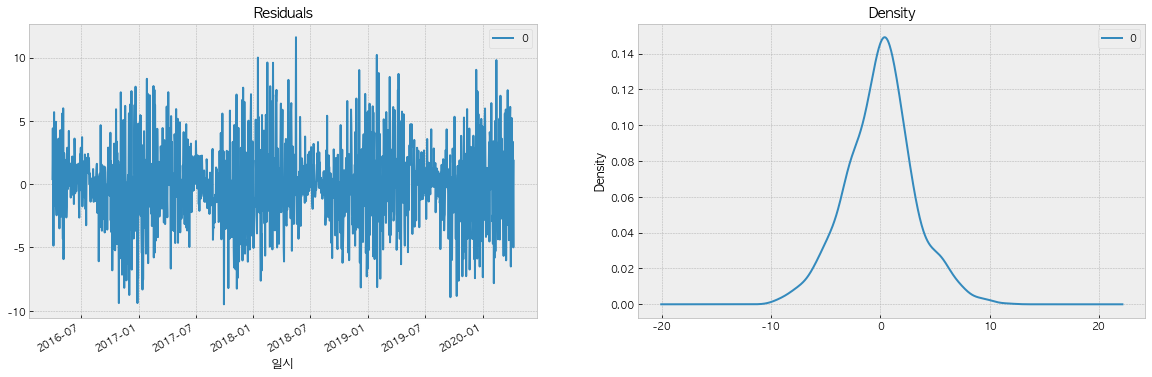

In [98]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize = (20,6))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [99]:
# 잔차의 정규성
# p-value > 0.05 이므로 정규분포따름.
from scipy.stats import normaltest 
normaltest(model_fit.resid)

NormaltestResult(statistic=10.37480558588479, pvalue=0.005586497279567824)

<Figure size 432x288 with 0 Axes>

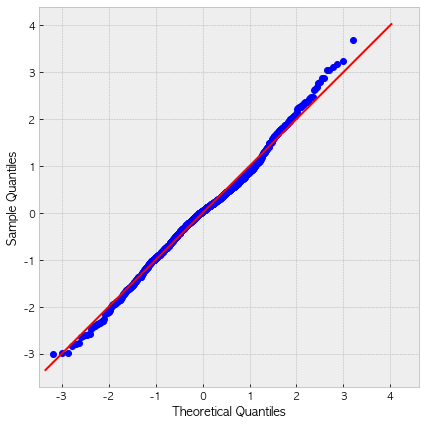

In [100]:
# q-q plot
fig = plt.figure()
fig = sm.qqplot(model_fit.resid, fit=True, line='45')
fig.set_size_inches(15,7)
plt.gca().axis("square")
plt.show()

### AutoArima

In [95]:
from pmdarima.arima import auto_arima
# Fit auto_arima function to dataset 
stepwise_fit = auto_arima(hour4_30.set_index('일시'), start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, 
                          m = 7,   # frequency of series
                          start_P = 0, 
                          seasonal = False,  # No Seasonality
                          d = None, D = 0, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=7541.524, BIC=7562.688, Time=0.275 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7887.264, BIC=7897.846, Time=0.048 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=7773.961, BIC=7789.834, Time=0.111 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=7626.938, BIC=7642.811, Time=0.150 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=7885.264, BIC=7890.555, Time=0.028 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=7536.247, BIC=7562.702, Time=0.336 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=7667.512, BIC=7688.676, Time=0.187 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=7538.242, BIC=7569.988, Time=0.553 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=7538.233, BIC=7569.979, Time=0.680 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=7536.342, BIC=7562.797, Time=0.376 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1468
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -3763.124
Date:                Sat, 06 Jun 2020   AIC                           7536.247
Time:                        08:53:59   BIC                           7562.702
Sample:                             0   HQIC                          7546.114
                               - 1468                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0015      0.017     -0.089      0.929      -0.035       0.032
ar.L1          0.3251      0.035      9.422      0.000       0.258       0.393
ar.L2         -0.0811      0.028     -2.869      0.004      -0.137      -0.026
ma.L1         -0.7939      0.027    -29.625      0.000      -0.846      -0.741
sigma2         9.8952      0.332     29.813      0.000       9.245      10.546
===================================================================================
Ljung-Box (Q):                       79.58   Jarque-Bera (JB):                13.54
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* AutoArima 로 산출된 p,d,q 값은 (2,1,1)

### AutoArima 모델 진단
* 잔차에 특정 패턴이 없어보이고, 정규성을 따르며, 자기상관도 없어보임.

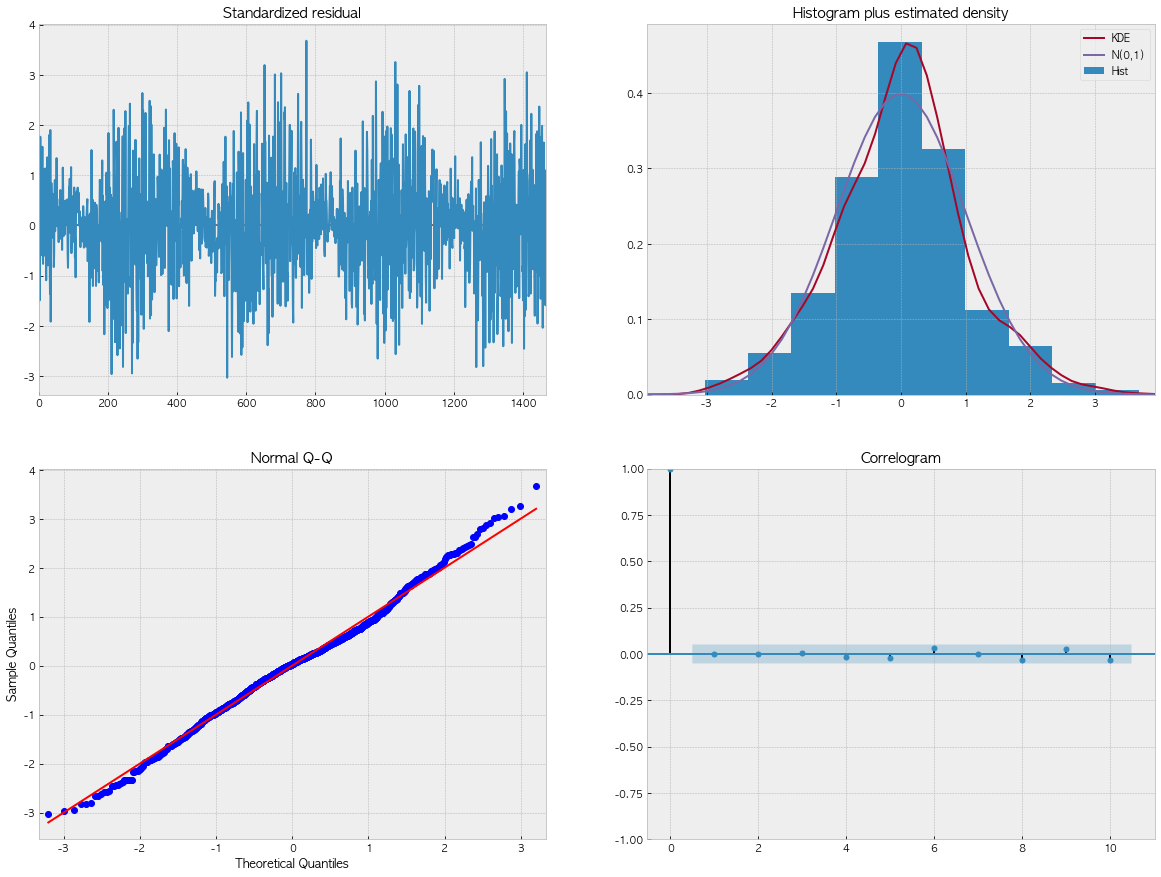

In [94]:
stepwise_fit .plot_diagnostics(figsize=(20,15))
plt.show()

### 최종 모델 적용
* 주관적으로 판단한 p,d,q = (4,1,2)
* auto arima 판단한 p,d,q=(2,1,1)

1) 주관적으로 판단한 p,d,q = (4,1,2)

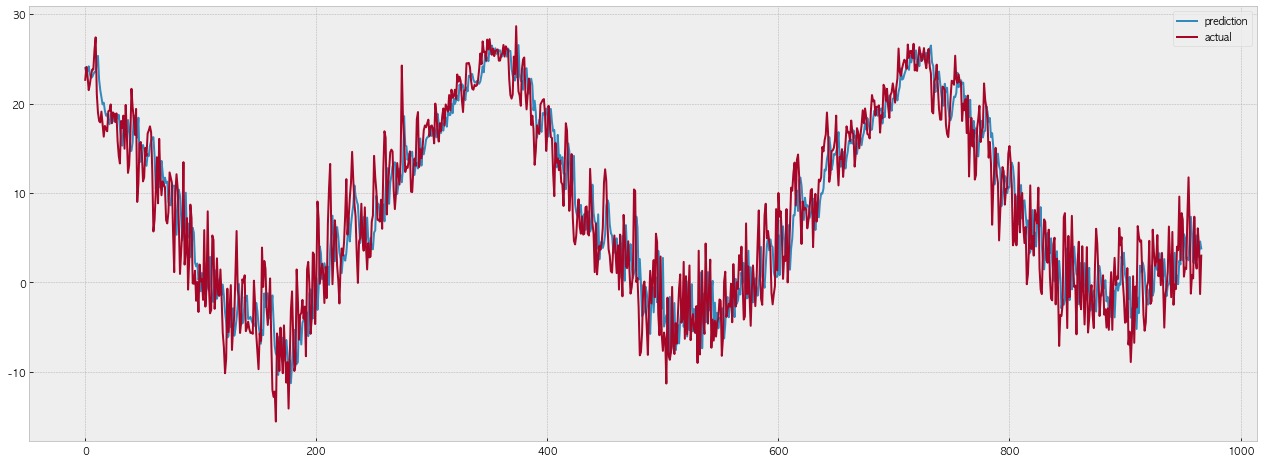

In [109]:
############################################## 실제 돌릴 코드
from statsmodels.tsa.arima_model import ARIMA
# i = 500,501,502,,,,1468
hour4_30=seosan_tem2[(seosan_tem2['일시'].apply(lambda x:x.hour)==4)]
hour4_30=hour4_30[(hour4_30['일시'].apply(lambda x:x.minute)==30)].reset_index(drop=True)

prediction=[]
actual=[]
period=500
for i in range(0, hour4_30.shape[0]-500-1):   # i = 0~966 (총1467이지만 그전까지 예측해야하므로)
    train=hour4_30.iloc[ i: period+i].set_index('일시')  # train= 0~500, 1~501, 2~502 ...(1466-500)=966~1466
    test=hour4_30.iloc[period+(i+1)]['기온']  # 501,502,503,,,,1467
    model = ARIMA(train, order=(2,1,2))
    model_fit = model.fit(trend='nc',full_output=True, disp=1)
    fore = model_fit.forecast(steps=1)
    
    prediction.append(fore[0][0])    # 예측값
    actual.append(test)      # 실제값

# prediction plot 과 실제값(test) plot 그리기.
fig,ax=plt.subplots()
fig.set_size_inches(22,8)
fig=plt.plot(prediction)
fig=plt.plot(actual)
plt.legend(['prediction','actual'])
plt.show()

2) auto arima 판단한 p,d,q=(2,1,1)

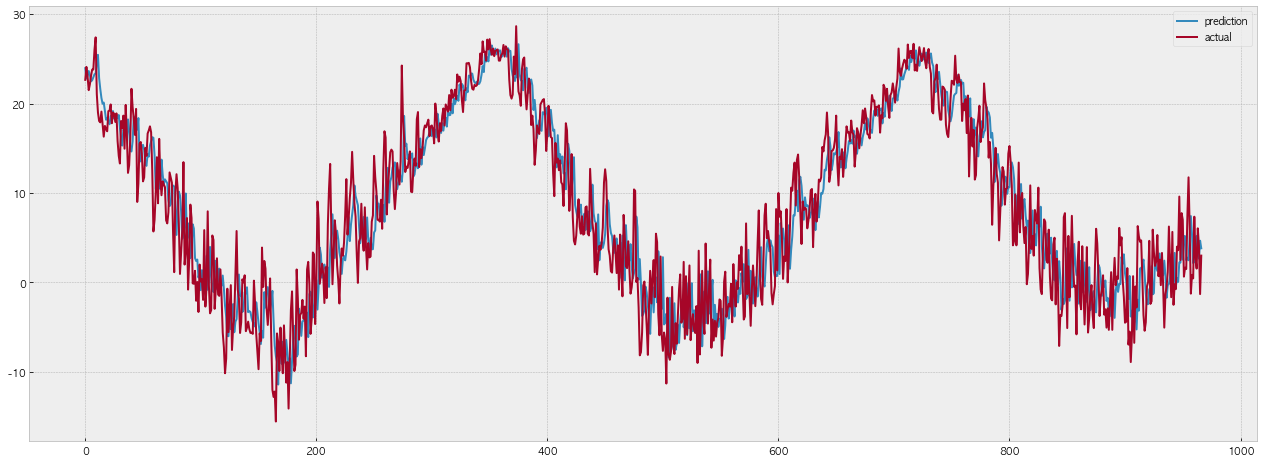

In [120]:
############################################## 실제 돌릴 코드
from statsmodels.tsa.arima_model import ARIMA
# i = 500,501,502,,,,1468
hour4_30=seosan_tem2[(seosan_tem2['일시'].apply(lambda x:x.hour)==4)]
hour4_30=hour4_30[(hour4_30['일시'].apply(lambda x:x.minute)==30)].reset_index(drop=True)

prediction=[]
actual=[]
period=500
for i in range(0, hour4_30.shape[0]-500-1):   # i = 0~966 (총1467이지만 그전까지 예측해야하므로)
    train=hour4_30.iloc[ i: period+i].set_index('일시')  # train= 0~500, 1~501, 2~502 ...(1466-500)=966~1466
    test=hour4_30.iloc[period+(i+1)]['기온']  # 501,502,503,,,,1467
    model = ARIMA(train, order=(2,1,1))
    model_fit = model.fit(trend='nc',full_output=True, disp=1)
    fore = model_fit.forecast(steps=1)
    
    prediction.append(fore[0][0])    # 예측값
    actual.append(test)      # 실제값

# prediction plot 과 실제값(test) plot 그리기.
fig,ax=plt.subplots()
fig.set_size_inches(22,8)
fig=plt.plot(prediction)
fig=plt.plot(actual)
plt.legend(['prediction','actual'])
plt.show()

In [121]:
prediction

[23.955735064904037,
 22.799082822732586,
 23.098468885416814,
 23.638650567104246,
 23.205185749452173,
 22.482886468984564,
 22.607161169701687,
 22.929239893575442,
 23.26863666455035,
 23.368095971845595,
 24.502801189788176,
 25.445444038024434,
 22.846244986561967,
 21.63532951272286,
 20.62641672461276,
 19.987053667686652,
 20.110039511847724,
 19.203288302596015,
 18.19201727791291,
 18.376517941957268,
 17.997856090810448,
 17.68326415244513,
 18.602340720088808,
 18.724671891597254,
 19.16538712683393,
 18.320720002333836,
 18.793653617369092,
 18.76170895006255,
 18.350673823665158,
 18.71992527825387,
 17.281328610209446,
 16.164110518270167,
 15.303119709276736,
 17.11109755554251,
 16.959759204275095,
 17.71161514617357,
 16.114217371465603,
 18.22318535929749,
 17.026142846939056,
 14.812285383686937,
 14.640358870783247,
 15.773656443980887,
 18.5655459644835,
 18.23427511550969,
 17.884307482812428,
 17.09143361494042,
 18.379022869427942,
 13.610790986770795,
 13.534

In [122]:
print('prediction:',len(prediction))
print('actual:',len(actual))

prediction: 967
actual: 967


In [123]:
# Load specific evaluation tools 
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 
  
# Calculate root mean squared error 
print('rmse:',rmse(actual,prediction) )

# Calculate mean squared error 
print('mean_squared_error:',mean_squared_error(actual,prediction) )

rmse: 3.8524304555023985
mean_squared_error: 14.841220414482416


In [124]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-actual)[1]                      # ACF1
    return({'mape':round(mape,3), 'me':round(me,3), 'mae': round(mae,3), 
            'mpe': round(mpe,3), 'rmse':round(rmse,3), 'acf1':round(acf1,3), 
            'corr':round(corr,3), 'minmax':round(minmax,3)})

forecast_accuracy(pd.Series(prediction), pd.Series(actual))

{'mape': inf,
 'me': 0.08,
 'mae': 3.029,
 'mpe': nan,
 'rmse': 3.852,
 'acf1': 0.308,
 'corr': 0.923,
 'minmax': inf}

In [66]:
hour4_30.iloc[0:500]

,일시,기온
0,2016-04-01 04:30:00,4.20
1,2016-04-02 04:30:00,4.60
2,2016-04-03 04:30:00,8.90
3,2016-04-04 04:30:00,7.15
4,2016-04-05 04:30:00,1.50
...,...,...
495,2017-08-09 04:30:00,23.45
496,2017-08-10 04:30:00,24.05
497,2017-08-11 04:30:00,22.50
498,2017-08-12 04:30:00,23.70


In [67]:
hour4_30.iloc[1:501]

,일시,기온
1,2016-04-02 04:30:00,4.60
2,2016-04-03 04:30:00,8.90
3,2016-04-04 04:30:00,7.15
4,2016-04-05 04:30:00,1.50
5,2016-04-06 04:30:00,3.10
...,...,...
496,2017-08-10 04:30:00,24.05
497,2017-08-11 04:30:00,22.50
498,2017-08-12 04:30:00,23.70
499,2017-08-13 04:30:00,24.20


In [19]:
plant_test.head()

,plant_test.mea_ddhr,plant_test.plant,plant_test.loc,plant_test.tem_in,plant_test.hum_in,plant_test.tem_coil,plant_test.tem_out_loc1,plant_test.hum_out_loc1,plant_test.x24h_tma,plant_test.x24h_cond_loc,plant_test.x48h_tma,plant_test.x48h_cond_loc
1,2019-04-01 00:00:00,2,3,8.17,40.42,10.10,4.20,54.82,2019-04-02 0:00,NaN,2019-04-03 0:00,NaN
2,2019-04-01 04:30:00,1,2,10.03,48.81,10.79,6.09,59.34,2019-04-02 4:30,NaN,2019-04-03 4:30,NaN
3,2019-04-01 10:30:00,2,3,9.45,40.93,9.07,12.26,32.14,2019-04-02 10:30,NaN,2019-04-03 10:30,NaN
4,2019-04-01 11:00:00,1,1,12.32,34.13,10.86,12.32,28.27,2019-04-02 11:00,NaN,2019-04-03 11:00,NaN
5,2019-04-01 13:30:00,2,1,11.28,22.65,8.76,12.01,19.84,2019-04-02 13:30,NaN,2019-04-03 13:30,NaN


In [127]:
plant1_train

,datetime,tem_in_loc1,hum_in_loc1,tem_coil_loc1,tem_in_loc2,hum_in_loc2,tem_coil_loc2,tem_in_loc3,hum_in_loc3,tem_coil_loc3,tem_out_loc1,hum_out_loc1,cond_loc1,cond_loc2,cond_loc3
1,2016-04-01 00:00:00,16.00,24.00,11.00,14.00,23.00,11.00,13.00,32.00,10.00,9.00,42.00,0.0,0.0,0.0
2,2016-04-01 03:00:00,14.00,28.00,10.00,12.00,32.00,9.00,11.00,42.00,7.00,7.00,59.00,0.0,0.0,0.0
3,2016-04-01 06:00:00,13.00,33.00,10.00,11.00,37.00,9.00,10.00,44.00,7.00,6.00,56.00,0.0,0.0,0.0
4,2016-04-01 09:00:00,13.00,33.00,10.00,11.00,35.00,9.00,10.00,41.00,8.00,18.00,30.00,0.0,0.0,0.0
5,2016-04-01 12:00:00,16.00,28.00,10.00,15.00,27.00,11.00,14.00,30.00,9.00,18.00,20.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58745,2019-03-31 23:10:00,10.52,36.39,10.52,10.55,35.20,11.17,9.85,37.88,9.79,6.40,43.86,0.0,0.0,0.0
58746,2019-03-31 23:20:00,10.52,37.09,10.44,10.55,35.53,11.09,9.88,38.40,9.72,6.34,44.02,0.0,0.0,0.0
58747,2019-03-31 23:30:00,10.43,37.18,10.56,10.49,35.65,11.21,9.85,38.22,9.91,6.40,43.04,0.0,0.0,0.0
58748,2019-03-31 23:40:00,10.49,38.00,10.56,10.55,36.08,11.21,9.82,38.95,9.83,6.31,45.33,0.0,0.0,0.0


### study (2020-06-06)
* 기온, 습도, 이슬점, 강수 변수 추가해서 회귀분석을 하고
    * 거기서 나온 오차를 가지구 ARIMAX 모형 적용
    * ARIMAX 모형에서는 오늘의 정보를 알고있어야 함.  
* LSTM
    * 7개 window로해서 변수는 증기압, 온도를 넣어서 예측

### sh's lesson
* 실제 기상청 날씨데이터로 결로여부 예측 로직
    * 로지스틱, 랜덤포레스트, xgboost 
    * 2016-04 ~ 2018-03 으로 train하고 2018-04  2019-03 예측

* todo
    * 실제 날씨 데이터로 결로여부를 로지스틱으로 예측
    * model만들어서 저장해놓기
        * 공장, loc, 24시간 48시간 후 결로여부

* step
    * 1. 기상 예측 > 2.공장/loc 별 로지스틱 분류 > 3. 파생변수 > 4.예측 